# K-Means Clustering

### The steps are broadly:

1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

### Problem Statement:
Using the K-means algorithm in Python with the analysis of the Online Store data set. We wanted to group the customers of the store into different clusters based on their purchasing habits.

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# 1. Read and Understand data

In [47]:
df = retail_df = pd.read_csv("data/OnlineRetail.csv", sep=",", encoding="ISO-8859-1", header=0)

In [48]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# 2. Clean the data

In [50]:
round(df.isnull().sum() * 100 /len(df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [51]:
df = df.dropna()

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


# 3. Data Prep

## a) RFM Analysis
1. R - Recency: How recently last transaction done
2. F - frequency: How much transaction
3. M - Monetary: How much money (revenue)

So create the new the data frame which includes these info.

In [53]:
#Monetary: 
#Add new column amount = quantity * unit price
df['amount'] = df['Quantity'] * df['UnitPrice']

/var/folders/_h/0w6p3n5s1ws5vvyt7k4_21700000gn/T/ipykernel_79020/3214743755.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['amount'] = df['Quantity'] * df['UnitPrice']


In [54]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [55]:
mont_df = df.groupby('CustomerID')['amount'].sum()
mont_df = mont_df.reset_index()
mont_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [56]:
#Frequency:
freq_df = df.groupby('CustomerID')['InvoiceNo'].count()
freq_df = freq_df.reset_index()
freq_df.columns = ['CustomerID', 'frequency']
freq_df.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [57]:
rfm_df = pd.merge(mont_df, freq_df, on='CustomerID', how='inner')
rfm_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
 8   amount       406829 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 31.0+ MB


In [59]:
#Recency:
#Convert the InvoiceDate to datatime formate.
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

/var/folders/_h/0w6p3n5s1ws5vvyt7k4_21700000gn/T/ipykernel_79020/3599350578.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [61]:
#Compute the max date.
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [62]:
#Compute the diff between max and invoice data.
df['diff'] = max_date - df['InvoiceDate']
df.head()

/var/folders/_h/0w6p3n5s1ws5vvyt7k4_21700000gn/T/ipykernel_79020/272327171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff'] = max_date - df['InvoiceDate']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [63]:
#Now create the recency column.
last_purchase = df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00
...,...,...
4367,18280.0,277 days 02:58:00
4368,18281.0,180 days 01:57:00
4369,18282.0,7 days 01:07:00
4370,18283.0,3 days 00:48:00


In [64]:
rfm_df = pd.merge(rfm_df, last_purchase, on='CustomerID', how='inner')
rfm_df.columns = ['CustomerID', 'amount','frequency', 'recency']
rfm_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [65]:
# We do not need the hours in recency only days are sufficient.
rfm_df['recency'] = rfm_df['recency'].dt.days
rfm_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


## b) Outlier treatment

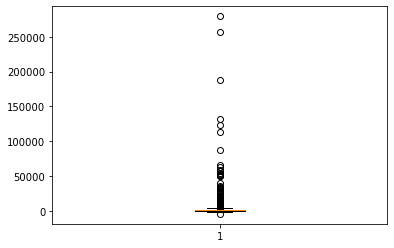

In [74]:
#Check outlier using boxplot
plt.boxplot(rfm_df['amount'])
plt.draw()


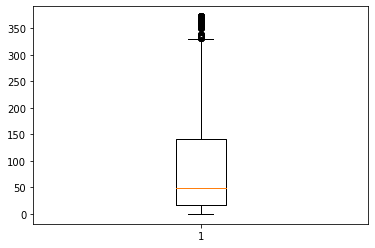

In [76]:
plt.boxplot(rfm_df['recency'])
plt.draw()

#### Note: Here are some outliers. But those are no need to remove.

## c) Rescale the values

In [77]:
rfm_dfs = rfm_df[['amount', 'frequency', 'recency']]

In [79]:
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_dfs)
rfm_df_scaled.shape

(4372, 3)

In [81]:
rfm_df_scaled

array([[-0.23100099, -0.3917197 ,  2.32202285],
       [ 0.29343167,  0.38265697, -0.89373323],
       [-0.01231622, -0.26695902, -0.1691956 ],
       ...,
       [-0.20951263, -0.34439668, -0.83418219],
       [ 0.02390005,  2.85205812, -0.87388289],
       [-0.00744423, -0.0991774 , -0.48680114]])

In [83]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.head()

,0,1,2
0,-0.231001,-0.391720,2.322023
1,0.293432,0.382657,-0.893733
2,-0.012316,-0.266959,-0.169196
3,-0.017146,-0.086271,-0.725005
4,-0.190312,-0.327188,2.163220


In [85]:
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.231001,-0.391720,2.322023
1,0.293432,0.382657,-0.893733
2,-0.012316,-0.266959,-0.169196
3,-0.017146,-0.086271,-0.725005
4,-0.190312,-0.327188,2.163220


# 4. Modelling

In [86]:
# K-means with random k value 4
kmeans = KMeans(n_clusters=4, max_iter=50)

In [89]:
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

#### Note: Here total 4 clusters are created.

In [88]:
kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0], dtype=int32)

## Get Optimal Number of Clusters

### 1. The elbow curve

In [92]:
ssd = []
cluster_range = [2,3,4,5,6,7,8]
for cluster_num in cluster_range:
    kmeans = KMeans(n_clusters=cluster_num, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    ssd.append(kmeans.inertia_)
    
ssd

[9000.344769281399,
 5408.404670803728,
 4013.833243507489,
 2937.955300849445,
 2323.1562394574735,
 1861.9612275864042,
 1616.0549371115503]

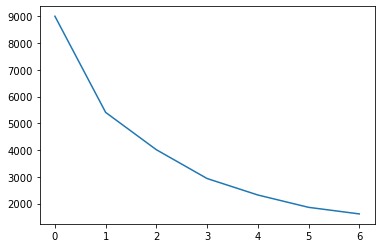

In [93]:
#plot the SSDs for each all clusters
plt.plot(ssd)

##### Note: Here 3 looks good number but not so significant.

### 2. The silhouette score
- It is measure the goodness of the clusters.
- silhouette score = p-q/max(p,q)
- p: inter cluster distance and q: is intra-cluster distance
- Its value range is -1 to 1.
- -1 is bad and +1 is good.

In [94]:
cluster_range = [2,3,4,5,6,7,8]
for cluster_num in cluster_range:
    kmeans = KMeans(n_clusters=cluster_num, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    clust_label = kmeans.labels_
    silh_avg = silhouette_score(rfm_df_scaled, clust_label)
    print('Clust_Num={0} Silh Score={1}'.format(cluster_num, silh_avg))
    

Clust_Num=2 Silh Score=0.9344641162235822
Clust_Num=3 Silh Score=0.6003883114752382
Clust_Num=4 Silh Score=0.5981422039499412
Clust_Num=5 Silh Score=0.6160117259955692
Clust_Num=6 Silh Score=0.5856955818362631
Clust_Num=7 Silh Score=0.523780832315049
Clust_Num=8 Silh Score=0.5077534162029627


#### Note: the 2 cluster mathematically is optimal. But business point of view, it could be 3 also.

## Cluster Analysis

In [95]:
#Lets consider the 3 cluster as optimal.
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [96]:
kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0], dtype=int32)

In [97]:
# Assigne the label 
rfm_df['cluster_id'] = kmeans.labels_
rfm_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


<AxesSubplot:xlabel='cluster_id', ylabel='recency'>

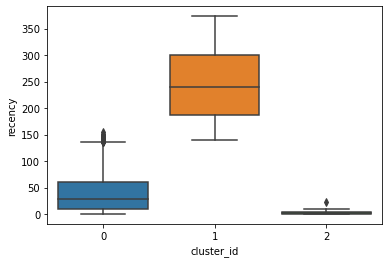

In [98]:
sns.boxplot(x='cluster_id', y='recency', data=rfm_df)

# Example:

In [99]:
df = retail_df = pd.read_csv("data/Cricket.csv", sep=",", encoding="ISO-8859-1", header=0)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  79 non-null     object 
 1   Span    79 non-null     object 
 2   Mat     79 non-null     int64  
 3   Inns    79 non-null     int64  
 4   NO      79 non-null     int64  
 5   Runs    79 non-null     int64  
 6   HS      79 non-null     object 
 7   Ave     79 non-null     float64
 8   BF      79 non-null     int64  
 9   SR      79 non-null     float64
 10  100     79 non-null     int64  
 11  50      79 non-null     int64  
 12  0       79 non-null     int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 8.1+ KB


In [106]:
dfs = df[['SR', 'Ave']]
scaler = StandardScaler()
dfs_scaled = scaler.fit_transform(dfs)
dfs_scaled.shape

(79, 2)

In [110]:
dfs_scaled = pd.DataFrame(dfs_scaled)
dfs_scaled.columns = ['SR', 'Ave']
dfs_scaled.head()

,SR,Ave
0,0.703152,1.072294
1,-0.044139,0.587725
2,0.110997,0.596226
3,1.207091,-1.047909
4,-0.034000,-0.876185


In [111]:
kmeans = KMeans(n_clusters=4, random_state=100)

In [112]:
kmeans.fit(dfs_scaled)

KMeans(n_clusters=4, random_state=100)

In [113]:
kmeans.labels_

array([3, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 0, 3, 2, 3, 2, 0, 1, 1, 0, 1,
       2, 1, 0, 3, 2, 0, 2, 1, 2, 2, 1, 2, 3, 2, 2, 1, 3, 1, 2, 2, 3, 2,
       2, 2, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 1, 0, 2, 0, 2, 0, 1, 3, 3, 1,
       1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 0, 2], dtype=int32)

In [114]:
df['cluster_id'] = kmeans.labels_

In [115]:
df.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,cluster_id
0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20,3
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15,1
2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20,1
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34,0
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28,2


In [133]:
dfa = df[['Player', 'cluster_id', 'Ave', 'SR']]

In [134]:
dfa.to_csv('output.csv', sep='\t', encoding='utf-8')

In [140]:
avg_df = dfa.groupby('cluster_id')['Ave'].mean()
avg_df = avg_df.reset_index()
avg_df

,cluster_id,Ave
0,0,35.409167
1,1,41.484444
2,2,33.949355
3,3,49.546667


In [141]:
sr_df = dfa.groupby('cluster_id')['SR'].mean()
sr_df = sr_df.reset_index()
sr_df

,cluster_id,SR
0,0,94.175833
1,1,75.751852
2,2,74.014839
3,3,88.273333
